In [1]:
#!pip install torchmetrics

In [3]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torchsummary import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


In [5]:
ROOT_DIR = '/content/drive/MyDrive/Project/Datasets/ocular-disease-recognition-odir5k'
ROOT_DIR = '../Datasets/ocular-disease-recognition-odir5k/'

In [18]:
IMAGE_FOLDER = ROOT_DIR + '/preprocessed_images'
CSV_PATH = ROOT_DIR + '/dataset_single_eye.csv'
TEST_CSV = ROOT_DIR + '/TESTING_dataset_single_eye.csv'
HIST_IMAGE_FOLDER = ROOT_DIR + '/preprocessed_histeq_images'

TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.8, 0.1, 0.1

NUM_CLASSES = 8

## Baseline: Efficient

### Processing

In [19]:
class ImageResizer:
    
    def __init__(self, image_width, quality, source_folder, destination_folder, file_name, keep_aspect_ratio):
        self.image_width = image_width
        self.quality = quality
        self.source_folder = source_folder
        self.destination_folder= destination_folder
        self.file_name = file_name
        self.keep_aspect_ration = keep_aspect_ratio

    def run(self):

        # We load the original file, we resize it to a smaller width and correspondent height and
        # also mirror the image when we find a right eye image so they are all left eyes

        file = os.path.join(self.source_folder, self.file_name)
        img = Image.open(file)

        if self.keep_aspect_ration:
            width_percentage = (self.image_width / float(img.size[0]))
            height_size = int((float(img.size[1]) * float(width_percentage)))
            img = img.resize((self.image_width, height_size), Image.ANTIALIAS)
        else:
            img = img.resize((self.image_width, self.image_width), Image.ANTIALIAS)
        if "right" in self.file_name:
            img.transpose(Image.Transpose.FLIP_LEFT_RIGHT).save(os.path.join(self.destination_folder, self.file_name), optimize=True, quality=self.quality)
        else:
            img.save(os.path.join(self.destination_folder, self.file_name), optimize=True, quality=self.quality)

In [20]:
SRC_PATH = ROOT_DIR + '/preprocessed_images'
DEST_PATH = ROOT_DIR + '/inception_preprocessed_images'

os.makedirs(DEST_PATH, exist_ok = True)

# files = [f for f in os.listdir(SRC_PATH) if os.path.isfile(os.path.join(SRC_PATH, f))]
# for file in tqdm(files):
#     ImageResizer(image_width = 299, quality = 100, source_folder = SRC_PATH, destination_folder = DEST_PATH, file_name = file, keep_aspect_ratio = False).run()

# files = [f for f in os.listdir(SRC_PATH) if not(os.path.isfile(os.path.join(DEST_PATH, f)))]
# print(len(files))

# for file in tqdm(files):
#     ImageResizer(image_width = 299, quality = 100, source_folder = SRC_PATH, destination_folder = DEST_PATH, file_name = file, keep_aspect_ratio = False).run()

In [21]:
# Mount Drive

In [22]:
csv = pd.read_csv(CSV_PATH)

csv = csv[csv['NOT DECISIVE'] == 0]

csv['img_exists'] = csv['Image'].apply(lambda x: os.path.isfile(IMAGE_FOLDER + "/" + x))

# drop the rows for which the file does not exist
csv = csv[csv['img_exists']]

csv.drop(columns = ['ID', 'eye', 'Patient Age',	'Patient Sex', 'NOT DECISIVE', 'img_exists'], inplace = True)
csv

,Image,Keywords,N,D,G,C,A,H,M,O
0,970_right.jpg,cataract,0,0,0,1,0,0,0,0
1,127_left.jpg,proliferative diabetic retinopathy，hypertensiv...,0,1,0,0,0,0,0,0
2,850_right.jpg,macular epiretinal membrane，moderate non proli...,0,1,0,0,0,0,0,0
3,37_right.jpg,normal fundus,1,0,0,0,0,0,0,0
4,4421_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5733,199_left.jpg,branch retinal vein occlusion,0,0,0,0,0,0,0,1
5734,516_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
5735,4603_left.jpg,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0
5736,2132_right.jpg,normal fundus,1,0,0,0,0,0,0,0


In [23]:
# images = [img.split('.', 1)[0] for img in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, img))]
# print(images[:5])

In [24]:
X = csv['Image'].to_numpy()
Y = csv.drop(['Image', "Keywords"], axis = 1).to_numpy()

print(X.shape)
print(Y.shape)

(5738,)
(5738, 8)


In [25]:
class ODIRDataset(Dataset) :
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        '''
        id : list of samples ids as string
        '''
        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform


        t = T.Resize((299,299),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        self.images = [t(torchvision.io.read_image(os.path.join(IMG_FOLDER, x))) for x in X]
        self.hist_images = [t(torchvision.io.read_image(os.path.join(HIST_IMG_FOLDER, x))) for x in X]
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        #img_path = os.path.join(self.image_dir, self.images[idx])
        #hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        
        #image = Image.open(img_path).convert("RGB")
        #hist_image = Image.open(hist_img_path)
        image = self.images[idx]
        hist_image = self.hist_images[idx]

        labels = torch.Tensor(self.labels[idx]).long()
        # t = T.Resize((299,299),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        # image = t(image)#.long()
        # hist_image = t(hist_image)
        # image = image.numpy()
        # hist_image = hist_image.numpy()
        if(self.transform != None) :
            image = image.numpy()
            hist_image = hist_image.numpy()
            image = np.transpose(image, (1,2,0))
            image = self.transform(image = image)['image']
            image = np.transpose(image, (2,0,1))
            
            hist_image = np.transpose(hist_image, (1,2,0))
            hist_image = self.transform(image = hist_image)['image']
            hist_image = np.transpose(hist_image, (2,0,1))
            image=torch.tensor(image)
            hist_image=torch.tensor(hist_image)

        return image, labels

In [26]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [27]:
BATCH_SIZE = 16
RANDOM_SEED = 69

In [29]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, RANDOM_SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

4590
573
575


In [31]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

287
36
36


torch.Size([3, 299, 299])


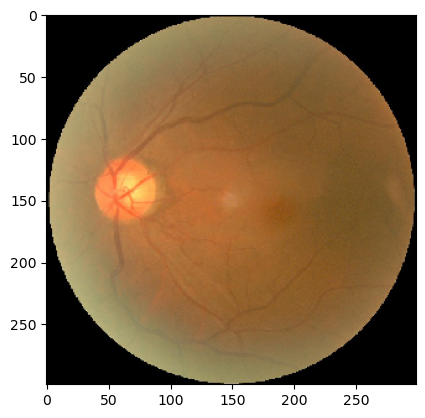

tensor([1, 0, 0, 0, 0, 0, 0, 0])


In [32]:
train_sample, train_label = train_dataset[9]

print(train_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()

# print(train_sample)
print(train_label)

### **MODEL ARCHITECTURE**

In [33]:
NUM_CLASSES = 8
LEARNING_RATE = 0.01
DECAY = 1e-6 
MOMENTUM = 0.9
NUM_EPOCHS = 10
PATIENCE = 4

In [34]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
# model = models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)
model = torchvision.models.efficientnet_b3(weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT).to(device)
num_ftrs = model.classifier[1].in_features
NUM_CLASSES = 8
model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
model = model.to(device)

# Freeze the weights of the base model
# for param in model.parameters():
#     param.requires_grad = False

# Replace the top layers of the base model
# num_features = model.fc.in_features

# model.fc = nn.Sequential(
#     nn.Linear(num_features, 1024),
#     nn.ReLU(inplace=True),
#     nn.Linear(1024, NUM_CLASSES),
#     nn.Sigmoid()
# )

# model = model.to(device)

# Print the model summary
# summary(model, (3, 299, 299))

In [35]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [36]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, min = epsilon, max = 1-epsilon)
    loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    mean_loss = torch.mean(loss)
    return mean_loss

def criterion(y_true_batch, y_pred_batch) :
    weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
    criterion = torch.nn.BCELoss(weight_class)
    B = y_true_batch.shape[0]
    loss = 0 
    for i in range(B) :
      loss += criterion(y_pred_batch[i],y_true_batch[i])
    return loss/B 

def predictions(scores) :
    
    B = scores.shape[0]
    predictions = torch.empty(B, NUM_CLASSES)
    
    for i in range(B) :
      pred = torch.empty(NUM_CLASSES,)
      for j in range(NUM_CLASSES) : 
        if(scores[i][j] > 0.5) :
          pred[j] = 1
        else :
          pred[j] = 0
      predictions[i] = pred

    return predictions 

In [37]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [38]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = DECAY, momentum = MOMENTUM, nesterov = True)
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

In [39]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    
total_t0 = time.time()

weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
criterion = torch.nn.BCELoss(weight_class)

In [40]:
for epoch in range(NUM_EPOCHS):

    model.train()   # Important when you are using BatchNorm or Dropout Layers as they work differenlty in testing and training.

    train_loss = 0 
    train_acc = 0 
    val_loss = 0
    val_acc = 0

    t0 = time.time()

    for batch_idx, (data, targets) in enumerate((train_dataloader)):

        if batch_idx % 10 == 0 and not batch_idx == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(batch_idx, len(train_dataloader), elapsed))

        optimizer.zero_grad() 

        data = data.to(device=device).float()
        targets = targets.to(device=device)

        scores = model(data)
        scores = torch.sigmoid(scores)

        loss = criterion(scores, targets.float())
        train_loss += loss.item()
        
        preds = predictions(scores).to(device)
        acc = (torch.sum(preds == targets)/(BATCH_SIZE*8))
        train_acc += acc

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_acc / len(train_dataloader)

    model.eval()

    with torch.no_grad():

      for batch_idx, (data, targets) in enumerate((val_dataloader)) :

        if batch_idx % 10 == 0 and not batch_idx == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(batch_idx, len(val_dataloader), elapsed))

        data = data.to(device=device).float()
        targets = targets.to(device=device)

        scores = model(data)
        scores = torch.sigmoid(scores)

        loss = criterion(scores, targets.float())
        val_loss += loss.item()

        preds = predictions(scores).to(device)
        val_acc += (torch.sum(preds == targets)/(BATCH_SIZE*8))

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_acc / len(val_dataloader)

    # wandb.log({'epoch': epoch, 'train_loss': avg_train_loss, 'train_acc': train_accuracy, 'val_loss': avg_val_loss, 'val_acc': val_accuracy})

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "f"Train Loss: {avg_train_loss:.4f}, "f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "f"Val Loss: {avg_val_loss:.4f}, "f"Val Accuracy: {val_accuracy:.4f}")

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        print('-'*60)
        break  

    print('-'*60)
    torch.cuda.empty_cache()

  Batch    10  of    287.    Elapsed: 0:00:07.
  Batch    20  of    287.    Elapsed: 0:00:10.
  Batch    30  of    287.    Elapsed: 0:00:12.
  Batch    40  of    287.    Elapsed: 0:00:14.
  Batch    50  of    287.    Elapsed: 0:00:16.
  Batch    60  of    287.    Elapsed: 0:00:18.
  Batch    70  of    287.    Elapsed: 0:00:20.
  Batch    80  of    287.    Elapsed: 0:00:22.
  Batch    90  of    287.    Elapsed: 0:00:25.
  Batch   100  of    287.    Elapsed: 0:00:27.
  Batch   110  of    287.    Elapsed: 0:00:29.
  Batch   120  of    287.    Elapsed: 0:00:31.
  Batch   130  of    287.    Elapsed: 0:00:33.
  Batch   140  of    287.    Elapsed: 0:00:35.
  Batch   150  of    287.    Elapsed: 0:00:37.
  Batch   160  of    287.    Elapsed: 0:00:39.
  Batch   170  of    287.    Elapsed: 0:00:42.
  Batch   180  of    287.    Elapsed: 0:00:44.
  Batch   190  of    287.    Elapsed: 0:00:46.
  Batch   200  of    287.    Elapsed: 0:00:48.
  Batch   210  of    287.    Elapsed: 0:00:50.
  Batch   220

In [41]:
torch.save(model.state_dict(), "eff_b3_normal.pt")

### Testing on split

In [42]:
model = model.train(False)

In [43]:
torch.cuda.empty_cache()

In [44]:
test_loss = 0
test_acc  = 0
for batch_idx, (data, targets) in enumerate((test_dataloader)):
    data = data.to(device).float()
    targets = targets.to(device)
    with torch.no_grad():
        scores = model(data)
        scores = torch.sigmoid(scores)

    loss = criterion(scores, targets.float())
    test_loss+= loss.item()
    preds = predictions(scores).to(device)
    test_acc+= (torch.sum(preds == targets)/(BATCH_SIZE*8))

avg_test_loss = test_loss/len(test_dataloader)
avg_test_acc  = test_acc /len(test_dataloader)

In [45]:
avg_test_loss, avg_test_acc.item()

(0.2891223339570893, 0.9090712070465088)

## Testing on preheld testing set

|Metric  |Value|
|:------:|-----|
|Accuracy|0.891|
|Loss    |0.330|

In [47]:
model = torchvision.models.efficientnet_b3(weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT).to(device)
num_ftrs = model.classifier[1].in_features
NUM_CLASSES = 8
model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
model.classifier[0] = torch.nn.Dropout(p=0.5, inplace=True)
model = model.to(device)

model.load_state_dict(torch.load("eff_b3_normal.pt"))
# Print the model summary
# summary(model, (3, 299, 299))

<All keys matched successfully>

In [48]:
test_csv = pd.read_csv(TEST_CSV)
test_csv = test_csv.drop(columns = ['ID', 'Patient Age', 'Patient Sex', 'eye', 'NOT DECISIVE'])
test_csv.head()

,Image,Keywords,N,D,G,C,A,H,M,O
0,1590_left.jpg,normal fundus,1,0,0,0,0,0,0,0
1,3137_left.jpg,normal fundus，lens dust,1,0,0,0,0,0,0,0
2,4182_right.jpg,normal fundus,1,0,0,0,0,0,0,0
3,3333_left.jpg,normal fundus,1,0,0,0,0,0,0,0
4,4459_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [59]:
X_test = test_csv['Image'].to_numpy()
Y_test = test_csv.drop(['Image', 'Keywords'], axis = 1).to_numpy()

X_test.shape, Y_test.shape

((638,), (638, 8))

In [60]:
BATCH_SIZE = 16

In [61]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, min = epsilon, max = 1-epsilon)
    loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    mean_loss = torch.mean(loss)
    return mean_loss

def criterion(y_true_batch, y_pred_batch) :
    B = y_true_batch.shape[0]
    loss = 0 
    for i in range(B) :
      loss += binary_cross_entropy(y_true_batch[i], y_pred_batch[i])
    return loss/B 

def predictions(scores) :
    
    B = scores.shape[0]
    predictions = torch.empty(B, NUM_CLASSES)
    
    for i in range(B) :
      pred = torch.empty(NUM_CLASSES,)
      for j in range(NUM_CLASSES) : 
        if(scores[i][j] > 0.5) :
          pred[j] = 1
        else :
          pred[j] = 0
      predictions[i] = pred

    return predictions 

In [62]:
weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
criterion = torch.nn.BCELoss(weight_class)

In [63]:
test_dataset = ODIRDataset(X_test, Y_test, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None)
test_dataloader_preheld = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
model = model.train(False)

In [65]:
torch.cuda.empty_cache()

In [66]:
test_loss = 0
test_acc  = 0
PREC = torchmetrics.classification.MultilabelPrecision(8, average = 'micro')#, validate_args = False)
ACC = torchmetrics.classification.MultilabelAccuracy(8, average = 'micro')#, validate_args = False)
REC = torchmetrics.classification.MultilabelRecall(8, average = 'micro')#, validate_args = False)
F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = 'micro')#, validate_args = False)
F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = 'micro')#, validate_args = False)
KAPPA = torchmetrics.classification.MulticlassCohenKappa(8)#, validate_args = False)
AUC = torchmetrics.classification.MultilabelAUROC(8, average = 'micro')#, validate_args = False)

for batch_idx, (data, targets) in enumerate((test_dataloader_preheld)):
    data = data.to(device).float()
    targets = targets.to(device)
    with torch.no_grad():
        scores = model(data)
        scores = torch.sigmoid(scores)
    loss = criterion(scores, targets.float())
    test_loss+= loss.item()
    predicted = predictions(scores).to(device)
    test_acc+= (torch.sum(predicted == targets)/(BATCH_SIZE*8))

    predicted = predicted.to('cpu')
    targets = targets.to('cpu')
    PREC(predicted, targets)
    ACC(predicted, targets)
    REC(predicted, targets)
    F1_SCORE(predicted, targets)
    F_BETA_SCORE(predicted, targets)
    KAPPA(predicted, targets)
    AUC(predicted, targets)


add_prec = PREC.compute()
add_acc = ACC.compute()
add_rec = REC.compute()
add_f1 = F1_SCORE.compute()
add_fbeta = F_BETA_SCORE.compute()
add_kappa = KAPPA.compute()
add_auc = AUC.compute()

avg_test_loss = test_loss/len(test_dataloader_preheld)
avg_test_acc  = test_acc /len(test_dataloader_preheld)

print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
torch.cuda.empty_cache()

Acc: 0.915556
Prec: 0.680628
Recall: 0.611
F1-score: 0.644
F-Beta-score: 0.652
Kappa: 0.596
AUC: 0.785


In [67]:
avg_test_loss, avg_test_acc.item()

(0.27920838017016647, 0.9126953482627869)